<a href="https://colab.research.google.com/github/paulg413/Forecasting-with-Prophet-in-Colab/blob/main/Forecasting_With_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Forecasting in Python using Prophet - Tutorial**


**Introduction **


Recently, I learned about Prophet (fbprophet). If you’re a Data Scientist who works with time-series data, you will love this tool.

For those not aware, Prophet was developed by Facebook to aid Data Scientists with automated forecasting for time-series data through its simple Sk-Learn style API.

Prophet can be fine-tuned by a data scientist to achieve more specificity. It is an additive forecasting model, and assumed that seasonal effects will be similar each year. Therefore, it doesn’t take a lot into account, but its accuracy can be improved over time through multiple feedback mechanisms. Its website states that Prophet works best with time-series data that has regular seasonality components and lots of historical data to refer to.
Since it is open-source, anyone can download and use Prophet. 

Rohan Gupta Dec 8 2019

**Students Note: The text information below is in case you want to adapt the code to run in another IDE such as VS Studio code, I have adapted this code to run in Colab**

Installation
I won’t go into much detail here, but since I did have some issues downloading Prophet for the first time, I’ll explain what I did to install it properly:
Firstly, you can try a simple pip install if that works:
pip install fbprophet
However, fbprophet has one major dependency that may cause problems: pystan
Ideally, you want to pip install pystan before fbprophet :
https://pystan.readthedocs.io/en/latest/installation_beginner.html
WINDOWS: pystan needs a compiler. Follow instructions here.
The easiest way is to install Prophet in anaconda. Use conda install gcc to set up gcc. Then install Prophet is through conda-forge:
conda install -c conda-forge fbprophet

In [33]:
#We will be using the following libraries for the tutorial. All basic libraries except Prophet.

import fbprophet
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from fbprophet import Prophet



For Dataset, I downloaded almost 10 years of game data for James Harden from https://www.basketball-reference.com/players/h/hardeja01.html. Essentially, we have data for almost every single game Harden has played (both in the Regular Season, as well as in the Playoffs.)
To use the same data that I’m using, head over to this GitHub https://github.com/dataxienxe/NBAplayersdata page and download the CSV files.


Below, I have imported each of the CSV files containing data on James Harden. ‘19rs’ would be “Regular Season 2019–2020” and ‘18po’ would be “Playoffs 2018–2019” to give you an idea of how each file is named.

In [34]:
#Note, for speed you can select/highlight all files you want to upload in a directory in one go 

from google.colab import files
uploaded = files.upload()

In [35]:
harden19rs = pd.read_csv('harden19rs.csv')
harden19po = pd.read_csv('harden19po.csv')
harden18rs = pd.read_csv('harden18rs.csv')
harden18po = pd.read_csv('harden18po.csv')
harden17rs = pd.read_csv('harden17rs.csv')
harden17po = pd.read_csv('harden17po.csv')
harden16rs = pd.read_csv('harden16rs.csv')
harden16po = pd.read_csv('harden16po.csv')
harden15rs = pd.read_csv('harden15rs.csv')
harden15po = pd.read_csv('harden15po.csv')
harden14rs = pd.read_csv('harden14rs.csv')
harden14po = pd.read_csv('harden14po.csv')
harden13rs = pd.read_csv('harden13rs.csv')
harden13po = pd.read_csv('harden13po.csv')
harden12rs = pd.read_csv('harden12rs.csv')
harden12po = pd.read_csv('harden12po.csv')
harden11rs = pd.read_csv('harden11rs.csv')
harden11po = pd.read_csv('harden11po.csv')
harden10rs = pd.read_csv('harden10po.csv')
harden10po = pd.read_csv('harden10rs.csv')
harden09rs = pd.read_csv('harden09rs.csv')

**Cleaning the Data**

The next step is super important as we want to make sure our data contains all the required fields or else we wouldn’t be able to do much with it.
Let’s start off by appending each of the CSV files. We can make them chronological as there’s a date component. First, we append each file in the following way:

In [36]:
harden = harden19rs.append(harden19po, ignore_index=True, sort=True)
harden = harden.append(harden18rs, ignore_index=True, sort=True)
harden = harden.append(harden18po, ignore_index=True, sort=True)
harden = harden.append(harden17rs, ignore_index=True, sort=True)
harden = harden.append(harden17po, ignore_index=True, sort=True)
harden = harden.append(harden16rs, ignore_index=True, sort=True)
harden = harden.append(harden16po, ignore_index=True, sort=True)
harden = harden.append(harden15rs, ignore_index=True, sort=True)
harden = harden.append(harden15po, ignore_index=True, sort=True)
harden = harden.append(harden14rs, ignore_index=True, sort=True)

...
harden = harden.append(harden09rs, ignore_index=True, sort=True)

**Next, I’ll rename some columns so we can understand what they are, and drop the unnecessary columns that aren’t required:**

In [46]:
harden = harden.rename(columns={'Unnamed: 7': 'Game', 'MP':'Mins'})
#harden['Game'] = pd.concat([harden['Unnamed: 7'].dropna(), harden['Game'].dropna()]).reindex_like(harden)
#harden = harden.drop(columns=['Unnamed: 7'])
harden = harden.drop(columns=['Unnamed: 5']) 
harden = harden.drop(columns=['▲'])
harden = harden.sort_values(by=['Date'])
harden = harden.reset_index(drop=True)


KeyError: ignored

**The final dataset looks like this: **

In [48]:
print(harden)


     +/-  3P    3P%  3PA  AST     Age  ...  Rk  STL TOV  TRB   Tm     Game
0    +16   1  0.500    2    3  20-069  ...   4    1   0    1  OKC   L (-3)
1      0   0  0.000    1    5  20-074  ...   6    2   0    4  OKC  W (+28)
2     +9   0  0.000    3    8  20-077  ...   8    1   2    5  OKC   W (+4)
3     -3   0  0.000    1    1  20-080  ...   9    1   2    2  OKC   W (+3)
4     -9   0  0.000    5    2  20-081  ...  10    1   2    3  OKC   L (-8)
..   ...  ..    ...  ...  ...     ...  ...  ..  ...  ..  ...  ...      ...
441   36   9  0.474   19    9  30-075  ...   9    2   6   10  HOU  W (+23)
442   -4   3  0.273   11    9  30-077  ...  10    2   6    4  HOU   W (+6)
443   10   7  0.538   13    7  30-079  ...  11    3   6    6  HOU   W (+9)
444   18   6  0.429   14    5  30-081  ...  12    4   3    8  HOU   W (+9)
445   16   8  0.364   22    6  30-082  ...  13    0   4    5  HOU  W (+20)

[446 rows x 29 columns]


**Setting the Index and Dropping nulls**

Since we want the data to be in chronological order, we set the date as our index value and change the datatype to a pandas datetime variable:

In [47]:
harden.set_index('Date')
harden['Date'] = pd.to_datetime(harden['Date'])

Next, we want to drop any null values in our data (even though I doubt we have any). We will use the pandas dropna function and will drop a row in which all values are null. Once we do that, we’ll reset the index to make sure it’s still coherent.

In [39]:
harden = harden.dropna(how='all')
harden = harden.reset_index(drop=True)

Next, we have another important step in the data cleanup. During some games, James Harden was inactive, suspended, did not play or did not dress. Certain columns would have these values “suspended” rather than the numeric value that should be there.
Thus, we can remove all the rows (games) in which Harden did not play/dress or was inactive/suspended. However, that might reduce the size of my data by a lot. So instead, I will replace the values with the median of each respective column.


In [40]:
for i in harden:
    harden[i] = harden[i].replace('Inactive', 
    np.median(pd.to_numeric(harden[i], errors='coerce')))
    
for i in harden:
    harden[i] = harden[i].replace('Did Not Play', 
    np.median(pd.to_numeric(harden[i], errors='coerce')))
    
for i in harden:
    harden[i] = harden[i].replace('Did Not Dress', 
    np.median(pd.to_numeric(harden[i], errors='coerce')))
    
for i in harden:
    harden[i] = harden[i].replace('Player Suspended', 
    np.median(pd.to_numeric(harden[i], errors='coerce')))
    
harden = harden.dropna(how='any')
harden = harden.reset_index(drop=True)
harden.set_index('Date')

,+/-,3P,3P%,3PA,AST,Age,BLK,DRB,FG,FG%,FGA,FT,FT%,FTA,G,GS,GmSc,Mins,ORB,Opp,PF,PTS,Rk,STL,TOV,TRB,Tm,Game
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-11-03,+16,1,.500,2,3,20-069,0,1,3,.333,9,2,1.000,2,4.0,0,6.5,17:04,0,LAL,2,9,4,1,0,1,OKC,L (-3)
2009-11-08,0,0,.000,1,5,20-074,0,3,2,.400,5,1,.500,2,6.0,0,7.8,19:13,1,ORL,3,5,6,2,0,4,OKC,W (+28)
2009-11-11,+9,0,.000,3,8,20-077,1,5,3,.375,8,1,.500,2,8.0,0,8.6,23:54,0,LAC,1,7,8,1,2,5,OKC,W (+4)
2009-11-14,-3,0,.000,1,1,20-080,1,1,3,.500,6,2,.667,3,9.0,0,4.4,19:57,1,SAS,4,8,9,1,2,2,OKC,W (+3)
2009-11-15,-9,0,.000,5,2,20-081,0,2,0,.000,8,4,1.000,4,10.0,0,-0.3,17:38,1,LAC,1,4,10,1,2,3,OKC,L (-8)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-09,36,9,0.474,19,9,30-075,0,9,12,0.444,27,9,0.818,11,9.0,1,32.4,35:48,1,CHI,1,42,9,2,6,10,HOU,W (+23)
2019-11-11,-4,3,0.273,11,9,30-077,1,4,13,0.52,25,10,0.714,14,10.0,1,27.7,38:16,0,NOP,4,39,10,2,6,4,HOU,W (+6)
2019-11-13,10,7,0.538,13,7,30-079,0,6,12,0.462,26,16,0.941,17,11.0,1,36.9,44:27,0,LAC,0,47,11,3,6,6,HOU,W (+9)


**Make sure your data types are on point**


A column containing numeric data should be explicitly assigned that datatype, in order to avoid errors in the future. Therefore, I will assign each column its correct data type. Using downcast='float' for float (decimal) columns.

In [41]:
harden['3P'] = pd.to_numeric(harden['3P'])
harden['3PA'] = pd.to_numeric(harden['3PA'])
harden['AST'] = pd.to_numeric(harden['AST'])
harden['BLK'] = pd.to_numeric(harden['BLK'])
harden['DRB'] = pd.to_numeric(harden['DRB'])
harden['ORB'] = pd.to_numeric(harden['ORB'])
harden['FG'] = pd.to_numeric(harden['FG'])
harden['FGA'] = pd.to_numeric(harden['FGA'])
harden['PTS'] = pd.to_numeric(harden['PTS'])
harden['PF'] = pd.to_numeric(harden['PF'])
harden['TOV'] = pd.to_numeric(harden['TOV'])
harden['STL'] = pd.to_numeric(harden['STL'])
harden['TRB'] = pd.to_numeric(harden['TRB'])
harden['3P%'] = pd.to_numeric(harden['3P%'], downcast='float')
harden['FG%'] = pd.to_numeric(harden['FG%'], downcast='float')
harden['FT%'] = pd.to_numeric(harden['FT%'], downcast='float')
harden['GmSc'] = pd.to_numeric(harden['GmSc'], downcast='float')
harden['FTA'] = pd.to_numeric(harden['FTA'])
harden['FT'] = pd.to_numeric(harden['FT'])
print(harden.dtypes)


+/-             object
3P               int64
3P%            float32
3PA              int64
AST              int64
Age             object
BLK              int64
DRB              int64
Date    datetime64[ns]
FG               int64
FG%            float32
FGA              int64
FT               int64
FT%            float32
FTA              int64
G              float64
GS              object
GmSc           float32
Mins            object
ORB              int64
Opp             object
PF               int64
PTS              int64
Rk               int64
STL              int64
TOV              int64
TRB              int64
Tm              object
Game            object
dtype: object


In [42]:
#Scroll back up to the prior dataframe to compare how the data has now been altered

print(harden)

     +/-  3P    3P%  3PA  AST     Age  ...  Rk  STL TOV  TRB   Tm     Game
0    +16   1  0.500    2    3  20-069  ...   4    1   0    1  OKC   L (-3)
1      0   0  0.000    1    5  20-074  ...   6    2   0    4  OKC  W (+28)
2     +9   0  0.000    3    8  20-077  ...   8    1   2    5  OKC   W (+4)
3     -3   0  0.000    1    1  20-080  ...   9    1   2    2  OKC   W (+3)
4     -9   0  0.000    5    2  20-081  ...  10    1   2    3  OKC   L (-8)
..   ...  ..    ...  ...  ...     ...  ...  ..  ...  ..  ...  ...      ...
441   36   9  0.474   19    9  30-075  ...   9    2   6   10  HOU  W (+23)
442   -4   3  0.273   11    9  30-077  ...  10    2   6    4  HOU   W (+6)
443   10   7  0.538   13    7  30-079  ...  11    3   6    6  HOU   W (+9)
444   18   6  0.429   14    5  30-081  ...  12    4   3    8  HOU   W (+9)
445   16   8  0.364   22    6  30-082  ...  13    0   4    5  HOU  W (+20)

[446 rows x 29 columns]


**Forecasting the Data**


Now to the best part. We will forecast any column in this dataset using Prophet. The output will give us an image (graph) of the forecast. In order to create the graph, we need to first fit the Prophet model to our dataset. We will separate the column we want, along with the date column. In this case, I’m predicting points, so I’ll take the ‘PTS’ and ‘Date’ columns.

In [43]:
df = harden[['PTS', 'Date']]

**Fitting**

These next steps are quite important, as we will be fitting the prophet model to our data. We want to rename our columns to ‘ds’ (date) and ‘y’ (target). We then define our Prophet model with any given interval_width. Then we fit our Prophet model to the dataset with the date and target variable.

In [44]:
jh = df.rename(columns={'Date': 'ds', 'PTS': 'y'})
jh_model = Prophet(interval_width=0.95)
jh_model.fit(jh)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


**To forecast values**, we use the make_future_dataframe function, specify the number of periods, frequency as ‘MS’, which is Multiplicative Seasonality.
We then create our matplotlib figure for the forecast. The image below the code shows you the output. 


Text(0.5, 1.0, 'James Harden Points')

<Figure size 1296x432 with 0 Axes>

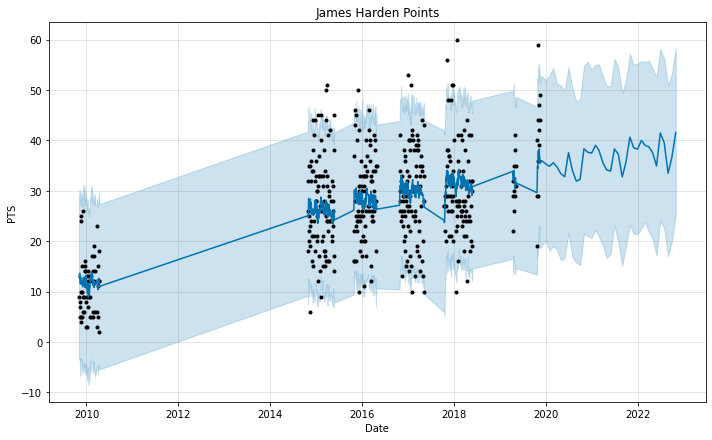

In [45]:
jh_forecast = jh_model.make_future_dataframe(periods=36, freq='MS')
jh_forecast = jh_model.predict(jh_forecast)
plt.figure(figsize=(18, 6))
jh_model.plot(jh_forecast, xlabel = 'Date', ylabel = 'PTS')
plt.title('James Harden Points')